# Multiclass classification for e-commerce

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/ecommerceDataset.csv", names=["class", "text"])

## EDA

In [4]:
print(df.loc[100,"text"])

Embroidery Kit for Beginners DIY Kit Total 15 Iteam This embroidery kit is consists of all the basic items that a beginner will require to learn embroidery. This kit can also be a perfect gift for your loved ones.


In [5]:
df.shape

(50425, 2)

Судя по распределению численности описаний карточек товаров, то придется применить технику андерсемплинга / оверсемплинга

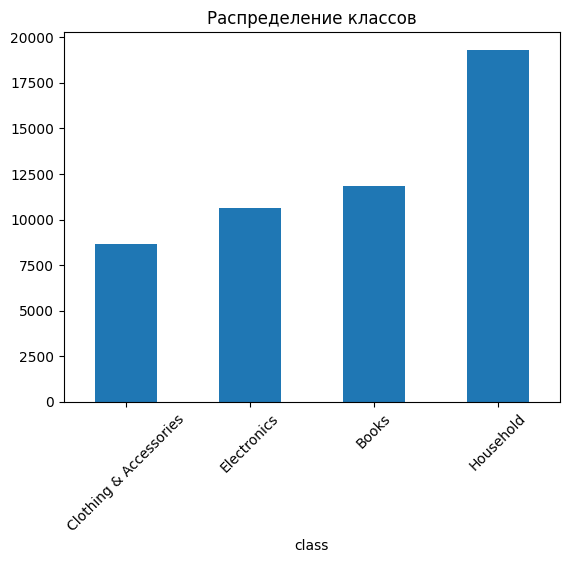

In [6]:
df["class"].value_counts().sort_values().plot(kind='bar') 
plt.title("Распределение классов")
plt.xticks(rotation=45)
plt.show()

In [7]:
df["class"] = df["class"].astype(str)
df["text"] = df["text"].astype(str)

In [8]:
df.loc[:,"len"] = df.text.apply(lambda x: len(x))
df.loc[:,"n"] = df.text.apply(lambda x: len(x.split()))

In [9]:
df["len"].describe()

count    50425.000000
mean       714.098245
std        973.370049
min          3.000000
25%        219.000000
50%        487.000000
75%        954.000000
max      50403.000000
Name: len, dtype: float64

In [10]:
df["n"].describe()

count    50425.000000
mean       114.182053
std        157.806212
min          1.000000
25%         34.000000
50%         78.000000
75%        152.000000
max       8181.000000
Name: n, dtype: float64

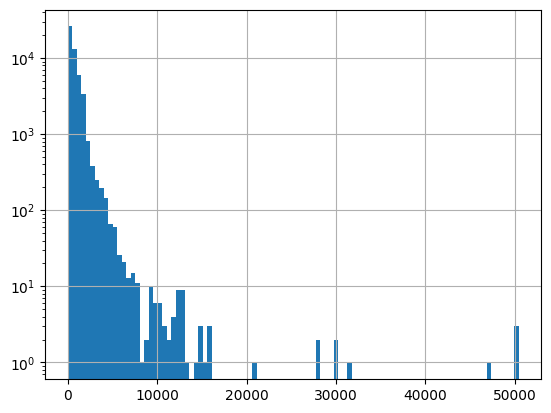

In [11]:
df["len"].hist(bins=100, log=True)
plt.show()

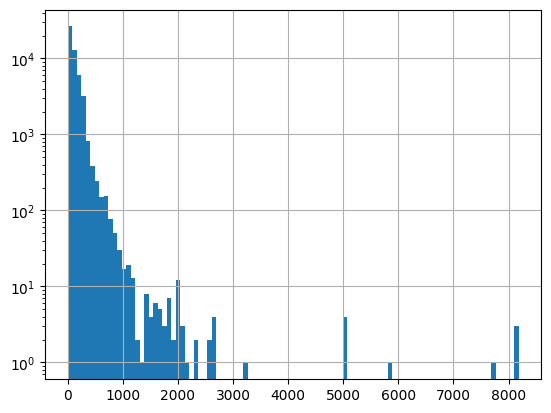

In [12]:
df["n"].hist(bins=100, log=True)
plt.show()

## Data processing

In [13]:
import numpy as np

In [14]:
df = df.drop_duplicates(subset=["class", "text"])
df.reset_index(inplace=True, drop=True)

In [15]:
df.shape

(27803, 4)

Нормальной практикой при очистке датасета является отброс 5-10 % данных 

In [16]:
min_n = np.percentile(df["n"], 2)
max_n = np.percentile(df["n"], 97)
min_n, max_n

(5.0, 350.0)

In [17]:
df = df[(df["n"] > min_n) & (df["n"] < max_n)]

In [18]:
df.shape

(26102, 4)

### Обработка текста

In [55]:
from string import punctuation

from tqdm import tqdm

import nltk 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [34]:
tqdm.pandas()

In [20]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fedorkurusin/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fedorkurusin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
STOPWORDS = set(stopwords.words('english'))

In [30]:
lemmatizer = WordNetLemmatizer()
wordnet_map = { 
    "N" : wordnet.NOUN, 
    "V" : wordnet.VERB, 
    "J" : wordnet.ADJ,
    "R" : wordnet.ADV
    }

def lemmatize_words(tokens):
    pos_tagged_text = nltk.pos_tag(tokens)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [31]:
def text_processing(text : str) -> str:
    # lowercase
    text = text.lower()
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))

    # remove stopwords
    tokens = [word for word in str(text).split() if word not in STOPWORDS]

    # lemmatization
    text = lemmatize_words(tokens)

    return text

In [35]:
df["text"] = df["text"].progress_apply(lambda x: text_processing(x))

100%|██████████| 26102/26102 [00:44<00:00, 582.68it/s]


In [37]:
df = df[["text", "class"]]

### Train test split

In [61]:
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["class"], test_size=0.33, shuffle=True, random_state=42, stratify=df["class"])

### Undersampling

In [75]:
rus = RandomUnderSampler(sampling_strategy='majority', replacement=True)
X_resampled, y_resampled = rus.fit_resample(
    X_train.values.reshape(-1, 1), 
    y_train.values.reshape(-1, 1)
    )

## Logistic Regression

In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [77]:
class_encoder = LabelEncoder()

In [78]:
y_train_encoded = class_encoder.fit_transform(y_train)
y_test_encoded = class_encoder.transform(y_test)

In [81]:
vectorizer = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2, 5),
    max_features=100_000,
    max_df=0.95,
    min_df=0.05,
)
X = vectorizer.fit_transform(X_train)

In [84]:
clf = LogisticRegression(random_state=0).fit(X, y_train_encoded)

/Users/fedorkurusin/Documents/hes/ai-in-buisness/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
X_test_vec = vectorizer.transform(X_test)

In [87]:
clf.score(X_test_vec, y_test_encoded)

0.9250058045042954